<h2> Figure with results from base-case trials</h2>

In [156]:
# Some imports to stop some annoying yellow underlines
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import importlib

# Very important line to run the setup notebook!!!
%run do_plot_setup.ipynb
import cl2_utilities as cl2_utils

# Extract some shared values that are used to facilitate plotting. Call 'display' on any of them to see their contents.
plot_default_properties = get_and_apply_plot_defaults() #Ignore yellow underline
line_default_properties = get_default_line_properties() #Ignore yellow underline
cl2_experiment_constants = get_cl2_experiment_constants() #Ignore yellow underline
(all_conversion_data,all_bypass_data) = get_experimental_data() #Ignore underline. These two dataframes have all the experimental results.

/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/process_cl2_logfile.py:38: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  dfs = {label: pd.read_csv(path,parse_dates={'Timestamp':[0,1]}) for label,path in zip(labels,paths)}
/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/process_cl2_logfile.py:38: DtypeWarning: Columns (46,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {label: pd.read_csv(path,parse_dates={'Timestamp':[0,1]}) for label,path in zip(labels,paths)}
/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/process_cl2_logfile.py:581: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  which_fields_prn = [i[0] for i in fields_prn_and_df]
/Users/maxkessler/Document

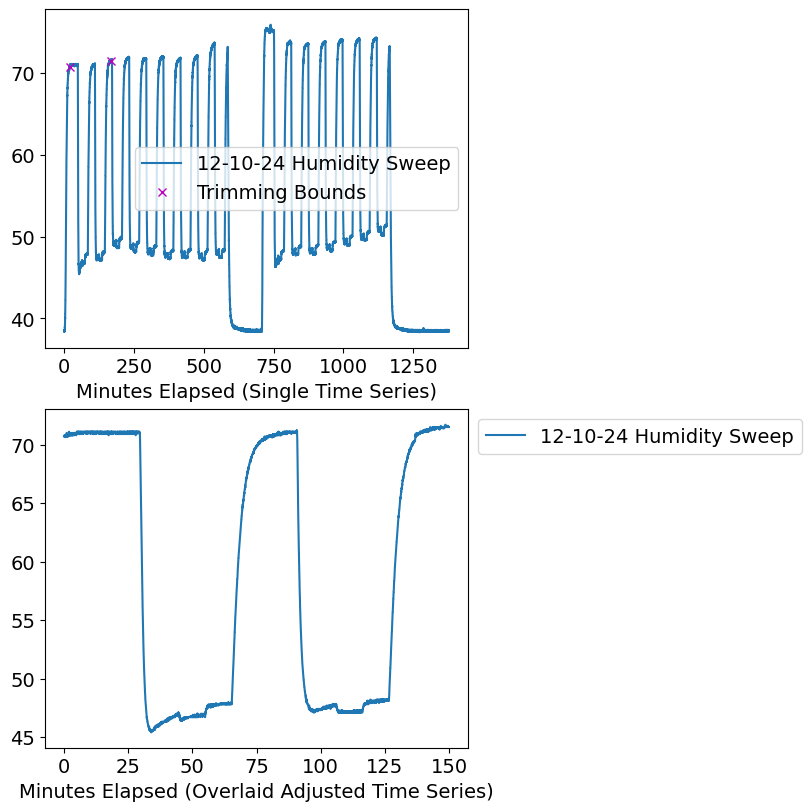

In [150]:
import process_cl2_logfile as process_cl2#This underline is unavoidable

path = (plot_default_properties['base_directory'] + '/10-23 Cl2 Campaign Follow-Ups/data/12-10-24_humidity.csv')
exp_name = '12-10-24 Humidity Sweep'
ftir_path = plot_default_properties['base_directory'] + '/10-23 Cl2 Campaign Follow-Ups/data/12-10_ftir.prn'

info = (path,exp_name,ftir_path)

# Load the file... (path,exp_name,ftir_path)
hush=True
raw_data = process_cl2.extract_data([info[:2]], hush)

# Rebind the ftir
ftir_fields_to_rebind = (('CH4 (PF) 191c average','FTIR: CH4 (ppm)'),('CO2 ppm 191c average','FTIR: CO2 (ppm)'),
                         ('CO ppm 191C (1of2) average','FTIR: CO (ppm)'),('Formaldehyde 191c average','FTIR: CH2O (ppm)'),)

process_cl2.rebind_ftir_prn(raw_data[exp_name],ftir_path,ftir_fields_to_rebind,hush)

for df in raw_data.values():
    try:
        df['FTIR: CH2O (ppm)']+=0.5 #One can see on inspection that the 'baseline' CH2O value is -0.5, not 0, for some reason. We correct that.
    except: #FTIR widget not used, or said 'no reading' the whole time.
        pass

importlib.reload(process_cl2)
trim_params = [(20, 170)]
(data, ax1, ax2) = process_cl2.trim_dataframes(raw_data, trim_params, plot=True, which_field='Cl2 LabJack: Cl2 Node A (mV)', which_df=0)
rf = process_cl2.RemovalFinder(data, "10-23_cl2_misc_follow_ups")

importlib.reload(process_cl2)
#@np.vectorize
def subtract_cl2_zero(mv):# This zero stays fixed within a given campaign but may change from campaign to campaign due to tweaking the Cl2 sensor setup
    return (mv-39.0)

current_experiment = '12-10-24 Humidity Sweep'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = subtract_cl2_zero(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='FTIR: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=1150,correct_drift=False)
#rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=ax_a,marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=1150,correct_drift=False)



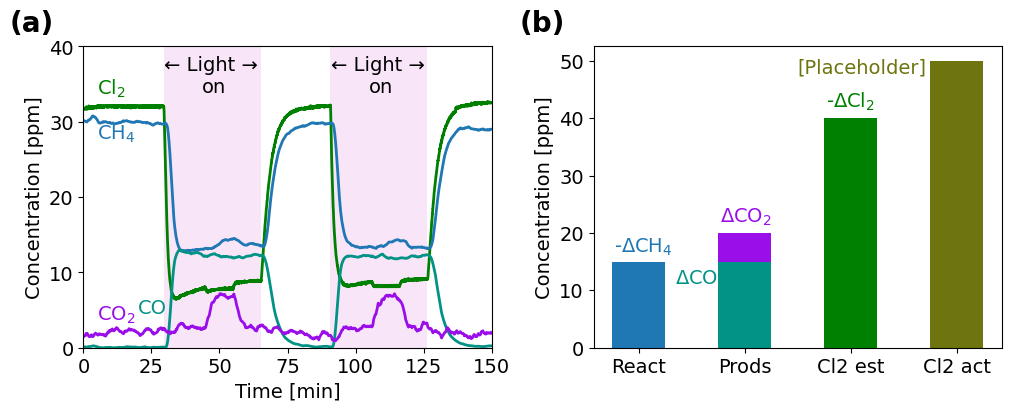

In [218]:
(fig,((ax_a,ax_b)))=plt.subplots(1,2,figsize=(plot_default_properties['figure_width'],4))

# a
ax_a.text(-0.18,1.05, "(a)", transform=ax_a.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')

importlib.reload(process_cl2)
importlib.reload(cl2_utils)

# Add the UV light overlays
(on_times,off_times) = process_cl2.find_UV_changes(data[current_experiment]['UV Light: Actual Status'],data[current_experiment]['Minutes'])
for i in range(len(on_times)):
    ax_a.axvspan(on_times.iloc[i],off_times.iloc[i], color='m', alpha=0.1, lw=0)
ax_a.text(.32,0.97, '← Light → \non',ha='center',va='top',transform=ax_a.transAxes)
ax_a.text(0.73,0.97, '← Light → \non',ha='center',va='top',transform=ax_a.transAxes)
#ax_a.plot(data[current_experiment]['Minutes'],10*data[current_experiment]['UV Light: Actual Status'],color='xkcd:purple',label='UV Light: Status (AU)')

#rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=ax_a,do_shading=False)
cl2_utils.do_timeseries(ax_a,line_default_properties,'Cl2',data[current_experiment]['Minutes'],data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'])
cl2_utils.do_timeseries(ax_a,line_default_properties,'CH4',data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CH4 (ppm)'])
cl2_utils.do_timeseries(ax_a,line_default_properties,'CO',data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO (ppm)'])
cl2_utils.do_timeseries(ax_a,line_default_properties,'CO2',data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'])

# Labeling
labels = (('Cl2',5,33,0),
          ('CH4',5,27,0),
          ('CO',20,4,0),
          ('CO2',5,3,0))
cl2_utils.label_tslines(ax_a,line_default_properties,labels)

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
ax_a.set_xlim(0,150)
ax_a.set_ylim(0,40)
ax_a.set_ylabel('Concentration [ppm]')
ax_a.set_xlabel('Time [min]')

#ax_a.plot([0],[0],'r*')

# b
ax_b.text(-0.18,1.05, "(b)", transform=ax_b.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')
# Data for the bar chart
bar_labels = ['React', 'Prods', 'Cl2 est', 'Cl2 act']
bar_values = [[15], [15, 5], [40], [50]]

# Labeling
labels = (('CH4',.05,.3,0),
          ('CO',.2,.2,0),
          ('CO2',.31,.4,0),
          ('Cl2',.57,.78,0),
          ('Cl* Efficiency',.5,.9,0))

# Create bar chart
j = 0
for i, values in enumerate(bar_values):
    bottom = 0
    for value in values:
        ax_b.bar(bar_labels[i], value, bottom=bottom, width=.5,color=line_default_properties[labels[j][0]]['color'])
        bottom += value
        j += 1

cl2_utils.label_lines(ax_b,line_default_properties,labels,True)

ax_b.set_ylabel('Concentration [ppm]')

plt.savefig('exported_images/base_case_results.png', bbox_inches='tight',dpi=300)
plt.show()